In [2]:
from __future__ import print_function
from orphics import maps,io,cosmology,stats
from pixell import enmap,curvedsky as cs,lensing
from enlib import bench
import numpy as np
import os,sys
import healpy as hp
from falafel import qe
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
"""
build d(T)
build d(E,B)
build d(E=0,B)
build d(E,B=0)

TT = G(d(T))
EE = G(d(E,B=0))
EB = G(d(E,B)) - EE
TB = G(d(T) + d(E=0,B)) - TT
TE = G(d(T) + d(E,B=0)) - EE - TT 
MV = G(d(T) + d(E,B))
MV_pol = G(d(E,B))

TT
EE
EE + EB
TT + EE + TE + EB + TB
"""

'\nbuild d(T)\nbuild d(E,B)\nbuild d(E=0,B)\nbuild d(E,B=0)\n\nTT = G(d(T))\nEE = G(d(E,B=0))\nEB = G(d(E,B)) - EE\nTB = G(d(T) + d(E=0,B)) - TT\nTE = G(d(T) + d(E,B=0)) - EE - TT \nMV = G(d(T) + d(E,B))\nMV_pol = G(d(E,B))\n\nTT\nEE\nEE + EB\nTT + EE + TE + EB + TB\n'

In [4]:
noiselevel=0

est = "temp"
#est = "pol"
#est = "mv"

thloc = "falafel/data/cosmo2017_10K_acc3"
theory = cosmology.loadTheorySpectraFromCAMB(thloc,get_dimensionless=False) ##!!!!!!

res = 2.0 # resolution in arcminutes
shape,wcs = enmap.fullsky_geometry(res=np.deg2rad(res/60.),proj="car")
#shape,wcs = enmap.band_geometry((np.deg2rad(-60.),np.deg2rad(30.)),res=np.deg2rad(res/60.), proj="car")
sim_location = "/scratch/r/rbond/msyriac/data/sims/alex/v0.4"
sindex = str(1).zfill(5)
mlmax = 4000

alm = maps.change_alm_lmax(
    hp.read_alm("/scratch/r/rbond/msyriac/data/sims/alex/v0.4/fullskyLensedUnabberatedCMB_alm_set01_%s.fits"
                % sindex,hdu=(1,2,3))
    ,mlmax)

lmax = 3000
lmin = 100

talm = alm[0]
ealm = alm[1]
balm = alm[2]

pix = qe.pixelization(shape=shape, wcs=wcs)

falm = qe.filter_alms(talm,lambda x: 1./theory.lCl('TT',x),lmin,lmax)
xalm = qe.filter_alms(talm,lambda x: 1,lmin,lmax)
#X_Ealm = qe.filter_alms(ealm,lambda x: 1,lmin,lmax)
#X_Balm = filter_alms(balm,lambda x: 1,lmin,lmax)
#Y_Ealm = filter_alms(ealm,lambda x: 1./theory.lCl('EE',x),lmin,lmax)
#Y_Balm = filter_alms(balm,lambda x: 1./theory.lCl('BB',x),lmin,lmax)

if est=="temp":
    with bench.show("recon tt"): recon = qe.qe_temperature_only(pix,xalm,falm,mlmax)[0] 


/scinet/niagara/intel/2018.2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide


34.02  8.38 14.66 recon tt


No handles with labels found to put in legend.


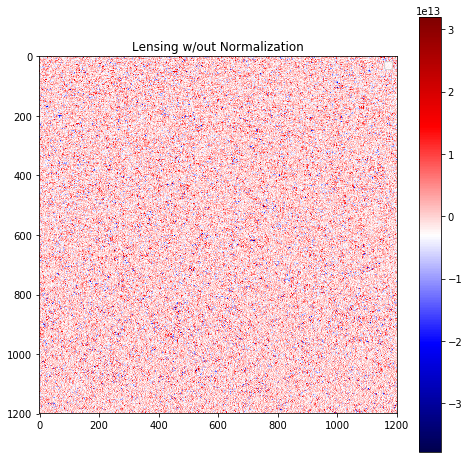

In [5]:
mappL = enmap.ndmap(np.zeros(shape), wcs)
cs.alm2map(recon, mappL)

fig = plt.figure(figsize = (8,8))
plt.title("Lensing w/out Normalization")
plt.imshow(mappL[3000:3000+1200, 5000:5000+1200],cmap='seismic')
plt.colorbar()
plt.legend()

In [6]:
#### Normalization #####

#import norm file
from tempura.pytempura.norm import get_norms

Tcmb  = 2.726e6    # CMB temperature
Lmax  = 3000       # maximum multipole of output normalization
lmax  = 3000
rlmin, rlmax = 100, 3000  # CMB multipole range for reconstruction
L = np.linspace(0,Lmax,Lmax+1)
l = L.copy()
Lfac = (L*(L+1.))**2/(2*np.pi) # Original Lfac
Lfac_lens = 1/(2*np.pi) # Did this to try to get a flat lens tt normalization plot.
LfacFromCosmology = 2.*np.pi/l/(l+1.) # from orphics.cosmology

lcl = np.zeros((4,lmax+1)) # TT, EE, BB, TE
lcl[:,2:] = [theory.lCl('TT',L[:lmax-1]),theory.lCl('EE',L[:lmax-1]),theory.lCl('BB',L[:lmax-1]),theory.lCl('TE',L[:lmax-1])] 

# lcl *= 2.*np.pi / (l**2+l+1e-30) / Tcmb**2

lcl *= 1 / Tcmb**2 

noise_tt = (noiselevel * np.pi/180/60)**2 / Tcmb**2 # conversion from arcminutes to radians^2

noise_ee, noise_bb = 2*noise_tt, 2*noise_tt


# oclnoise = [(lcl[0]+noise_tt)*1., (lcl[1])*1., (lcl[2])*1., (lcl[3])*1.]  # observed Cl, noise added to tt lcl

ocl = [(lcl[0])*1., (lcl[1])*1., (lcl[2])*1., (lcl[3])*1.]  # observed Cl, NO noise added to tt lcl

# Construction of dictionaries necessary for the norm functions.

# oclsnoise = {'TT' : oclnoise[0], 'EE': oclnoise[1], 'BB': oclnoise[2], 'TE': oclnoise[3]} 

ocls = {'TT' : ocl[0], 'EE': ocl[1], 'BB': ocl[2], 'TE': ocl[3]} 

lcls = {'TT' : lcl[0], 'EE': lcl[1], 'BB': lcl[2], 'TE': lcl[3]} 


# Norm Calculator. Cannot call tau and lens in the same function call. Returns Aest as a dictionary of arrays

# Aestnoise = get_norms(['tt'],lcls,oclsnoise,rlmin,rlmax,coupling=["lens"]) # including noise

##### !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Aest = get_norms(['tt'],lcls,ocls,rlmin,rlmax,coupling=["lens"])

/scinet/niagara/intel/2018.2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


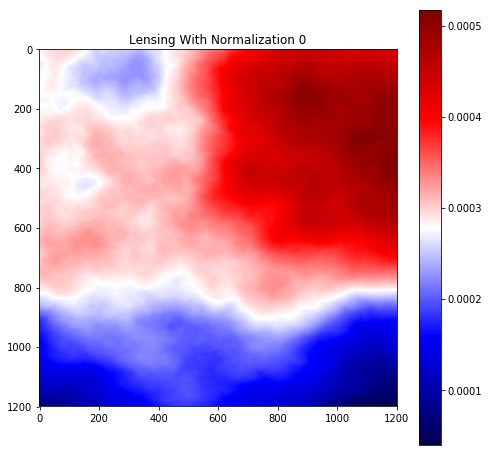

In [7]:
### Mutliply ###

#newalm = cs.map2alm(mappL, lmax=lmax)

final_alm0 = hp.almxfl(recon, 2*Aest['tt'][0])

mapplens0 = enmap.ndmap(np.zeros(shape),wcs)

cs.alm2map(final_alm0, mapplens0)

plt.figure(figsize=(8,8))
plt.title("Lensing With Normalization 0")
plt.imshow(mapplens0[3000:3000+1200, 5000:5000+1200],cmap='seismic')
plt.colorbar()

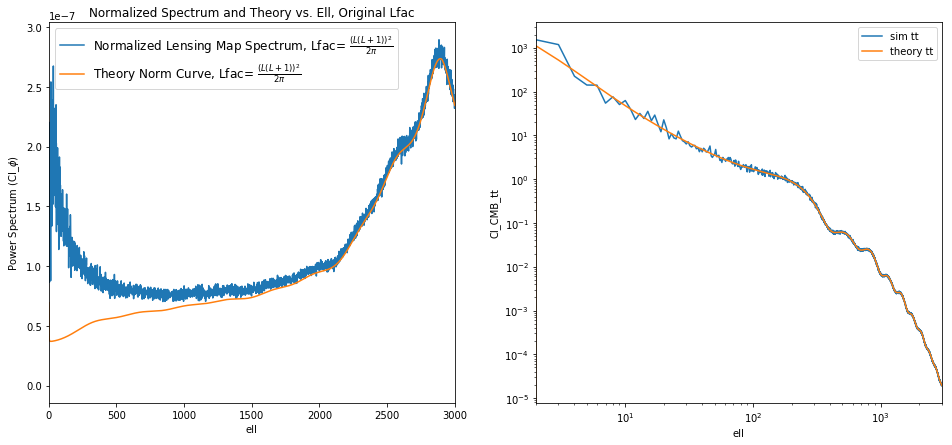

In [9]:
# plot normalization and lensing map power spectra

plt.figure(figsize=(16,7))

ax1 = plt.subplot(121, xlabel="ell", ylabel=r"Power Spectrum (Cl_$\phi$)", xlim=(2,3000)) #yscale='log') #xscale='log',

if noiselevel != 0:
    for est in Aestnoise:
        ax1.plot(L,Lfac*Aestnoise[est][0], label='Theory Curve, Noise, '+est)
    
plt.title("Normalized Spectrum and Theory vs. Ell, Original Lfac")
    
norm_ps0 = hp.alm2cl(final_alm0)

ax1.plot(L, Lfac*norm_ps0[:3001], label= r"Normalized Lensing Map Spectrum, Lfac= $\frac{(L(L+1))^2}{2\pi}$")
# factors of L turn it into kappa from phi

ax1.plot(L, Lfac*Aest['tt'][0], label=r'Theory Norm Curve, Lfac= $\frac{(L(L+1))^2}{2\pi}$')

ax1.legend(prop={"size":12})

##############################################
ax2 = plt.subplot(122, xlabel="ell", ylabel="Cl_CMB_tt", xlim=(2,3000), xscale='log', yscale="log")

tcls = hp.alm2cl(talm)

ax2.plot(L, tcls[:3001], label="sim tt")
ax2.plot(theory.lCl('TT',L), label="theory tt")

ntt = []
for i in range(len(L)):
    ntt.append(noise_tt)
    
if noiselevel !=0:
    ax2.plot(L, ntt, label="Inputted Noise Value")
    
ax2.legend();